## Current work 
- There are 119 unique common names in the sample dataset, I need to determine which items I care about and what I want to show
- Determining a more efficient way to plot multiple common names, say 20 or more without intensively passing plot arguments to each
## Ideas
- Adding relevant geographic items like roads, waterways, and reservations which will provide context to the respective bird species' observed location(s)

## Clean-up
- Pythonic formatting of datapoint plotting 

## Sources / References
- https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
- [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)

### Import Libraries

In [48]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

### eBird Data

In [2]:
# Read the data and view with head()
bird_data = pd.read_csv('ebird_data_cpmap.csv')
bird_data.head()

,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,OBSERVATION COUNT,BREEDING BIRD ATLAS CODE,...,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,TRIP COMMENTS,SPECIES COMMENTS,Column1
0,URN:CornellLabOfOrnithology:EBIRD:OBS570779581,1/24/2018 14:41,19073.0,species,American Crow,Corvus brachyrhynchos,NaN,NaN,2,NaN,...,2,1,NaN,0,1,0,NaN,NaN,NaN,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS563756637,1/3/2018 22:54,19073.0,species,American Crow,Corvus brachyrhynchos,NaN,NaN,2,NaN,...,2,1,G2836759,0,1,0,NaN,NaN,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS563333659,1/3/2018 22:54,19073.0,species,American Crow,Corvus brachyrhynchos,NaN,NaN,2,NaN,...,2,1,G2836759,0,1,0,NaN,NaN,NaN,NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS563148351,1/9/2018 21:46,19073.0,species,American Crow,Corvus brachyrhynchos,NaN,NaN,1,NaN,...,2,1,G2836779,0,1,0,NaN,NaN,NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS566089279,1/10/2018 16:17,19073.0,species,American Crow,Corvus brachyrhynchos,NaN,NaN,1,NaN,...,1,0,NaN,0,1,0,NaN,NaN,NaN,NaN


In [3]:
#Create subset
subset = bird_data[[
    'GLOBAL UNIQUE IDENTIFIER',
    'COMMON NAME',
    'OBSERVATION COUNT',
    'COUNTY',
    'COUNTY CODE',
    'LATITUDE',
    'LONGITUDE',
    'OBSERVATION DATE',
]]

# Change the county code from AL-101 to the US Federal Information Processing Standard 01101
subset.loc[:, 'COUNTY CODE'] = '01101'
    
subset

C:\Users\bsand\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,GLOBAL UNIQUE IDENTIFIER,COMMON NAME,OBSERVATION COUNT,COUNTY,COUNTY CODE,LATITUDE,LONGITUDE,OBSERVATION DATE
0,URN:CornellLabOfOrnithology:EBIRD:OBS570779581,American Crow,2,Montgomery,01101,32.253150,-86.351219,1/5/2018
1,URN:CornellLabOfOrnithology:EBIRD:OBS563756637,American Crow,2,Montgomery,01101,32.188361,-86.368160,1/2/2018
2,URN:CornellLabOfOrnithology:EBIRD:OBS563333659,American Crow,2,Montgomery,01101,32.188361,-86.368160,1/2/2018
3,URN:CornellLabOfOrnithology:EBIRD:OBS563148351,American Crow,1,Montgomery,01101,32.348862,-86.289228,1/2/2018
4,URN:CornellLabOfOrnithology:EBIRD:OBS566089279,American Crow,1,Montgomery,01101,32.378946,-86.299321,1/10/2018
...,...,...,...,...,...,...,...,...
1934,URN:CornellLabOfOrnithology:EBIRD:OBS566333425,Yellow-rumped Warbler,4,Montgomery,01101,32.356063,-86.018177,1/11/2018
1935,URN:CornellLabOfOrnithology:EBIRD:OBS568461744,Yellow-rumped Warbler,1,Montgomery,01101,32.340859,-86.183667,1/17/2018
1936,URN:CornellLabOfOrnithology:EBIRD:OBS567597105,Yellow-rumped Warbler,2,Montgomery,01101,32.377678,-86.229222,1/14/2018
1937,URN:CornellLabOfOrnithology:EBIRD:OBS572943868,Yellow-rumped Warbler,2,Montgomery,01101,32.380433,-86.230874,1/31/2018


#### Exploratory Analysis

In [26]:
# Frequency chart
fq = subset[['COMMON NAME', 'OBSERVATION COUNT']]

# Isolate the top 10 bird by total observation count 
fq_sum = fq.groupby('COMMON NAME').sum().nlargest(10, 'OBSERVATION COUNT')
fq_sum.reset_index(inplace=True)
fq_sum

,COMMON NAME,OBSERVATION COUNT
0,Ring-billed Gull,10033
1,American Robin,4913
2,Red-winged Blackbird,2912
3,European Starling,2510
4,Double-crested Cormorant,2143
5,blackbird sp.,1415
6,Great Egret,1035
7,Brown-headed Cowbird,777
8,Canada Goose,755
9,Ruddy Duck,638


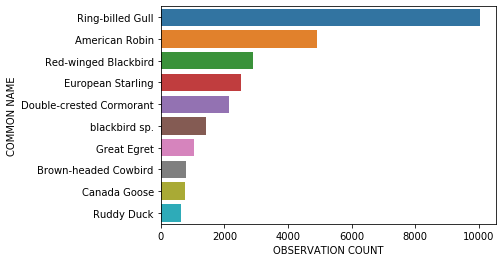

In [31]:
fq_plot = sns.barplot(data = fq_sum, x='OBSERVATION COUNT', y='COMMON NAME')
fq_plot

In [38]:
# Create list of the above common names
top_ten = []
for i in fq_sum['COMMON NAME']:
    top_ten.append(i)
top_ten

['Ring-billed Gull',
 'American Robin',
 'Red-winged Blackbird',
 'European Starling',
 'Double-crested Cormorant',
 'blackbird sp.',
 'Great Egret',
 'Brown-headed Cowbird',
 'Canada Goose',
 'Ruddy Duck']

### Geographic Data

In [40]:
# Create a column with the geometry points
geometry = [Point(xy) for xy in zip(subset['LONGITUDE'],subset['LATITUDE'])]

# Set the coordinate reference system
crs = {'init': 'epsg:26929'}

# Create the GeoDataFrame
bird_gdf = gpd.GeoDataFrame(subset, crs = crs, geometry=geometry)
tweet_plot = bird_gdf[bird_gdf['COMMON NAME'].isin(top_ten)] # GeoDataFrame with top ten  
tweet_plot


,GLOBAL UNIQUE IDENTIFIER,COMMON NAME,OBSERVATION COUNT,COUNTY,COUNTY CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,geometry
58,URN:CornellLabOfOrnithology:EBIRD:OBS570778450,American Robin,1,Montgomery,01101,32.437062,-86.312563,1/4/2018,POINT (-86.3125634 32.4370618)
59,URN:CornellLabOfOrnithology:EBIRD:OBS563756360,American Robin,12,Montgomery,01101,32.253150,-86.351219,1/2/2018,POINT (-86.35121940000001 32.2531502)
60,URN:CornellLabOfOrnithology:EBIRD:OBS563070429,American Robin,12,Montgomery,01101,32.253150,-86.351219,1/2/2018,POINT (-86.35121940000001 32.2531502)
61,URN:CornellLabOfOrnithology:EBIRD:OBS571637719,American Robin,5,Montgomery,01101,32.223119,-86.119096,1/27/2018,POINT (-86.119096 32.223119)
62,URN:CornellLabOfOrnithology:EBIRD:OBS563756634,American Robin,40,Montgomery,01101,32.188361,-86.368160,1/2/2018,POINT (-86.36816020000001 32.1883615)
...,...,...,...,...,...,...,...,...,...
1658,URN:CornellLabOfOrnithology:EBIRD:OBS569925972,Ruddy Duck,65,Montgomery,01101,32.346813,-86.032711,1/21/2018,POINT (-86.03271099999999 32.346813)
1659,URN:CornellLabOfOrnithology:EBIRD:OBS565144370,Ruddy Duck,5,Montgomery,01101,32.336278,-86.034536,1/7/2018,POINT (-86.03453640000001 32.3362785)
1660,URN:CornellLabOfOrnithology:EBIRD:OBS566333423,Ruddy Duck,125,Montgomery,01101,32.356063,-86.018177,1/11/2018,POINT (-86.01817700000001 32.356063)
1661,URN:CornellLabOfOrnithology:EBIRD:OBS566325980,Ruddy Duck,2,Montgomery,01101,32.334450,-86.038452,1/11/2018,POINT (-86.03845200000001 32.33445)


In [6]:
# Create the GeoDataFrame with the city border geographic data
dir_path = r'C:\Users\bsand\297P\Projects\geographic_plotting\cb_2018_us_cbsa_500k.shp'
map_df = gpd.read_file(dir_path)
map_df.head()

,CSAFP,CBSAFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,None,31340,310M400US31340,31340,"Lynchburg, VA",M1,5491925729,68559452,"POLYGON ((-79.85840499999999 37.267155, -79.85..."
1,488,42220,310M400US42220,42220,"Santa Rosa, CA",M1,4081491107,497455304,"POLYGON ((-123.533535 38.768408, -123.52851 38..."
2,None,24900,310M400US24900,24900,"Greenwood, MS",M2,3165909249,48172332,"POLYGON ((-90.453755 33.276255, -90.453104 33...."
3,538,46140,310M400US46140,46140,"Tulsa, OK",M1,16238554204,492994165,"POLYGON ((-97.06448499999999 36.681061, -97.06..."
4,None,18260,310M400US18260,18260,"Cookeville, TN",M2,2960951070,35466926,"POLYGON ((-85.84648299999999 36.288167, -85.83..."


In [32]:
# Isolate Montgomery, AL
mx = map_df.loc[map_df['NAME'] == 'Montgomery, AL']
mx

,CSAFP,CBSAFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
131,None,33860,310M400US33860,33860,"Montgomery, AL",M1,7029491093,187230524,"POLYGON ((-86.92119599999999 32.657542, -86.92..."


### Plotting
Plot the top birds by observation count

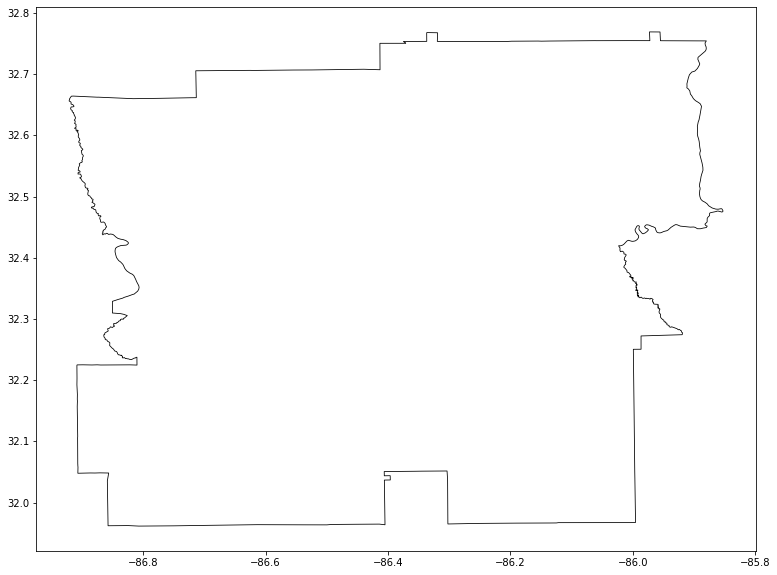

In [8]:
# Plot unfilled polygon of Montgomery, AL with datapoints
# fig, ax = plt.subplots(figsize = (16,10))
# mx.plot(ax = ax, facecolor='none',edgecolor='black',lw=0.8)
# bird_gdf[bird_gdf['COMMON NAME'] == 'American Crow'].plot(ax = ax,
#                                                           markersize = 70, 
#                                                           color = 'blue', 
#                                                           marker = '.',
#                                                           label = 'American Crow')
# bird_gdf[bird_gdf['COMMON NAME'] == 'Yellow-rumped Warbler'].plot(ax = ax, 
#                                                                   markersize = 70, 
#                                                                   color = 'red', 
#                                                                   marker = 'x',
#                                                                   label = 'Yellow-rumped Warbler')
# bird_gdf[bird_gdf['COMMON NAME'] == 'Bufflehead'].plot(ax = ax, 
#                                                        markersize = 70, 
#                                                        color = 'orange', 
#                                                        marker = '2',
#                                                        label = 'Bufflehead')
# plt.legend(prop={'size':15})

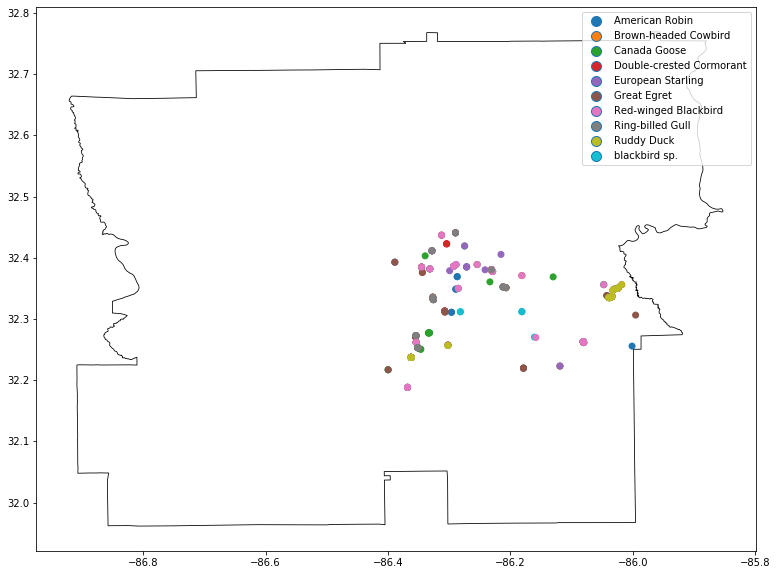

In [80]:
# Defining figure 
fig, ax = plt.subplots(figsize = (16,10))

# Plot unfilled Montgomery, AL polygon
mx.plot(ax = ax, facecolor='none',edgecolor='black',lw=0.8)

# # eBird data assignment
tweet_plot.plot(ax=ax, c='Paired', column='COMMON NAME', legend=True)

In [57]:
name
ar = collections.Counter(name)
ar

Counter({'American Robin': 67,
         'blackbird sp.': 17,
         'Brown-headed Cowbird': 24,
         'Canada Goose': 50,
         'Double-crested Cormorant': 46,
         'European Starling': 26,
         'Great Egret': 50,
         'Red-winged Blackbird': 66,
         'Ring-billed Gull': 32,
         'Ruddy Duck': 21})

Currently trying to troubleshoot the plotting. It does not appear that each categorical data point is being plotted. Above I used collections Counter() method to see how many individually logged observations there are for each bird in the top ten. 